In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

data_dir = '../../dataset/HiT_CA4_DGC_filtered.h5ad'
adata = sc.read_h5ad(data_dir)
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/RandomMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=8192,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 190662798 stored elements and shape (56367, 18752)>
  Coords	Values
  (0, 10785)	5.0
  (0, 13830)	3.0
  (0, 9792)	1.0
  (0, 361)	3.0
  (0, 11996)	31.0
  (0, 11375)	1.0
  (0, 11866)	1.0
  (0, 1413)	1.0
  (0, 3893)	5.0
  (0, 13348)	3.0
  (0, 8872)	3.0
  (0, 1239)	2.0
  (0, 17254)	5.0
  (0, 11793)	4.0
  (0, 9121)	1.0
  (0, 1474)	2.0
  (0, 10369)	2.0
  (0, 9327)	1.0
  (0, 11060)	1.0
  (0, 10047)	1.0
  (0, 7166)	1.0
  (0, 7878)	2.0
  (0, 16110)	3.0
  (0, 6831)	1.0
  (0, 9236)	3.0
  :	:
  (56366, 17768)	4.0
  (56366, 8372)	1.0
  (56366, 1045)	2.0
  (56366, 17383)	1.0
  (56366, 1783)	5.0
  (56366, 13757)	3.0
  (56366, 14311)	3.0
  (56366, 4387)	1.0
  (56366, 16352)	4.0
  (56366, 103)	2.0
  (56366, 12074)	1.0
  (56366, 10922)	1.0
  (56366, 8267)	1.0
  (56366, 6187)	2.0
  (56366, 8250)	1.0
  (56366, 17441)	1.0
  (56366, 4186)	1.0
  (56366, 212)	1.0
  (56366, 16186)	1.0
  (56366, 10277)	1.0
  (56366, 9604)	1.0
  (56366, 1530)	3.0
  (5

In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

11

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 18752
匹配的基因列表: {'polg', 'actr2', 'or5k3', 'cacng7', 'btg1', 'apaf1', 'or2j2', 'nol4', 'znf24', 'zdhhc20', 'ncr3', 'larp7', 'dusp19', 'fkbp4', 'daam1', 'snrpa1', 'phf6', 'myo7a', 'ctso', 'scgb2a2', 'tbc1d24', 'stag1', 'znf729', 'spryd3', 'naaa', 'celsr1', 'prrg2', 'lyzl4', 'mrfap1l1', 'traf3', 'ube2l3', 'rab9a', 'nsd3', 'slc16a5', 'zkscan7', 'ly6g5c', 'odad3', 'sacm1l', 'larp4', 'ddx5', 'fosb', 'ttc28', 'tmem41b', 'dok7', 'asah1', 'thap9', 'endod1', 'selenov', 'znf214', 'igfl2', 'dusp22', 'prph', 'pkd2', 'clk3', 'cox7a1', 'or2z1', 'mansc4', 'rpf2', 'znf280d', 'mgam2', 'cib3', 'or2a12', 'cd300a', 'mospd1', 'mdm2', 'nlrp10', 'zscan30', 'kiaa2026', 'znf304', 'hoxa2', 'plcb3', 'bcar1', 'rims3', 'mrpl43', 'bnipl', 'il33', 'ppp2r5c', 'adam17', 'trappc13', 'znf441', 'efcc1', 'gal', 'tbl1xr1', 'tpst1', 'chit1', 'poteb3', 'stau2', 'smyd1', 'pdrg1', 'cep20', 'pald1', 'slf1', 'ccser1', 'lingo1', 'tfam', 'erfe', 'itgax', 'efnb2', 'fndc8', 'tomm40l', 'exoc6b', 'steap1', 'prickle1', 'casp2',

set()

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻所有层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.0797749999461416, Validation Loss: 0.00312892678714807
Validation loss improved to 0.00312892678714807, resetting patience.


Epoch 2, Train Loss: 0.003797029266228776, Validation Loss: 0.0023549373548379282
Validation loss improved to 0.0023549373548379282, resetting patience.


Epoch 3, Train Loss: 0.0018544477777595603, Validation Loss: 0.002310383091475187
No improvement in validation loss. Patience counter: 1/20


Epoch 4, Train Loss: 0.0032762651462999023, Validation Loss: 0.0015167314198783087
Validation loss improved to 0.0015167314198783087, resetting patience.


Epoch 5, Train Loss: 0.0022404594595041988, Validation Loss: 0.0036262765949581378
No improvement in validation loss. Patience counter: 1/20


Epoch 6, Train Loss: 0.0033209939312705515, Validation Loss: 0.0038390503946005477
No improvement in validation loss. Patience counter: 2/20


Epoch 7, Train Loss: 0.0028441200450517886, Validation Loss: 0.002446853789744616
No improvement in validation loss. Patience counter: 3/20


Epoch 8, Train Loss: 0.0038449544793400514, Validation Loss: 0.0012856786906668412
Validation loss improved to 0.0012856786906668412, resetting patience.


Epoch 9, Train Loss: 0.0016247468926012605, Validation Loss: 0.0014116048818108532
No improvement in validation loss. Patience counter: 1/20


Epoch 10, Train Loss: 0.001446458132328707, Validation Loss: 0.0026446610899555126
No improvement in validation loss. Patience counter: 2/20


Epoch 11, Train Loss: 0.0017269604316456008, Validation Loss: 0.0014685046161682987
No improvement in validation loss. Patience counter: 3/20


Epoch 12, Train Loss: 0.001660755100486476, Validation Loss: 0.002101574134482024
No improvement in validation loss. Patience counter: 4/20


Epoch 13, Train Loss: 0.0013615205586137574, Validation Loss: 0.0023129274068544384
No improvement in validation loss. Patience counter: 5/20


Epoch 14, Train Loss: 0.0016921526271065192, Validation Loss: 0.0016057616245911416
No improvement in validation loss. Patience counter: 6/20


Epoch 15, Train Loss: 0.0010071420663657266, Validation Loss: 0.004869752820846386
No improvement in validation loss. Patience counter: 7/20


Epoch 16, Train Loss: 0.002765723745165163, Validation Loss: 0.0026429991846305934
No improvement in validation loss. Patience counter: 8/20


Epoch 17, Train Loss: 0.0021325164104130908, Validation Loss: 0.0009922874465784315
Validation loss improved to 0.0009922874465784315, resetting patience.


Epoch 18, Train Loss: 0.001057475660763489, Validation Loss: 0.002073484416359988
No improvement in validation loss. Patience counter: 1/20


Epoch 19, Train Loss: 0.0013569344822949173, Validation Loss: 0.0021929471494963305
No improvement in validation loss. Patience counter: 2/20


Epoch 20, Train Loss: 0.0006210958388280257, Validation Loss: 0.0016720582036117463
No improvement in validation loss. Patience counter: 3/20


Epoch 21, Train Loss: 0.0020110258223929238, Validation Loss: 0.0024038179504415566
No improvement in validation loss. Patience counter: 4/20


Epoch 22, Train Loss: 0.0022521570965399478, Validation Loss: 0.0033433228416643304
No improvement in validation loss. Patience counter: 5/20


Epoch 23, Train Loss: 0.002530481098406039, Validation Loss: 0.005095025651905378
No improvement in validation loss. Patience counter: 6/20


Epoch 24, Train Loss: 0.0019791712267319926, Validation Loss: 0.0017973391182239686
No improvement in validation loss. Patience counter: 7/20


Epoch 25, Train Loss: 0.0017407041170763762, Validation Loss: 0.007218248207575461
No improvement in validation loss. Patience counter: 8/20


Epoch 26, Train Loss: 0.003606616411626513, Validation Loss: 0.0036434148691036014
No improvement in validation loss. Patience counter: 9/20


Epoch 27, Train Loss: 0.002018751626072558, Validation Loss: 0.0015461286792192842
No improvement in validation loss. Patience counter: 10/20


Epoch 28, Train Loss: 0.0010889395488864171, Validation Loss: 0.0010393471999587923
No improvement in validation loss. Patience counter: 11/20


Epoch 29, Train Loss: 0.0008392564038891854, Validation Loss: 0.00226723636856359
No improvement in validation loss. Patience counter: 12/20


Epoch 30, Train Loss: 0.0007038743315428506, Validation Loss: 0.004101507300827001
No improvement in validation loss. Patience counter: 13/20


Epoch 31, Train Loss: 0.0006346405736774959, Validation Loss: 0.006204525286356106
No improvement in validation loss. Patience counter: 14/20


Epoch 32, Train Loss: 0.0014733228297690612, Validation Loss: 0.0024319318252899367
No improvement in validation loss. Patience counter: 15/20


Epoch 33, Train Loss: 0.0012526362572930845, Validation Loss: 0.003514915438707463
No improvement in validation loss. Patience counter: 16/20


Epoch 34, Train Loss: 0.002320707878103225, Validation Loss: 0.0011130429348992544
No improvement in validation loss. Patience counter: 17/20


Epoch 35, Train Loss: 0.0021995994941029643, Validation Loss: 0.0031550027941627773
No improvement in validation loss. Patience counter: 18/20


Epoch 36, Train Loss: 0.0026814929603886936, Validation Loss: 0.0025256983952193267
No improvement in validation loss. Patience counter: 19/20


Epoch 37, Train Loss: 0.003406977449966633, Validation Loss: 0.0026029870822547358
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 37.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


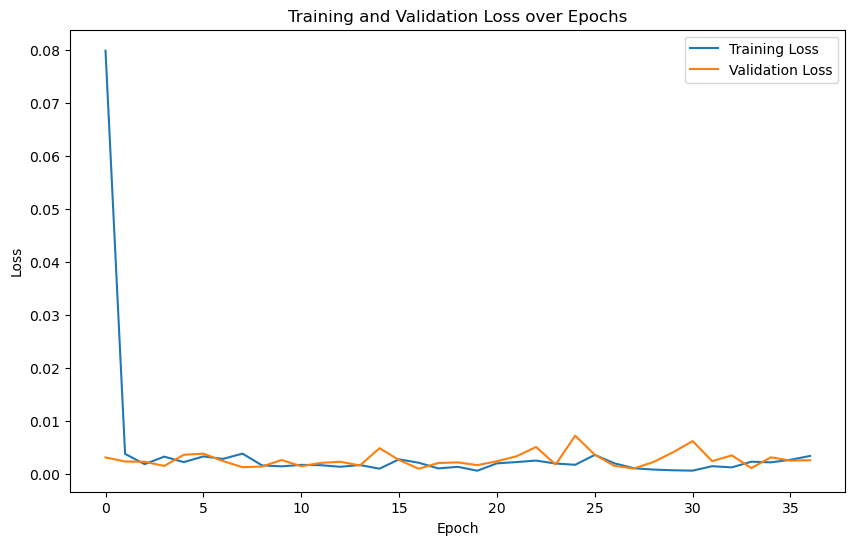

In [12]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [13]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [14]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.9996452223273415
Weighted F1 Score: 0.999639124931487
Macro F1 Score: 0.9731804168827721
Random Guess Accuracy: 0.4721198844214674
                                        precision    recall  f1-score   support

                             astrocyte       1.00      1.00      1.00       567
     central nervous system macrophage       1.00      1.00      1.00       266
                      endothelial cell       1.00      1.00      1.00        28
                        ependymal cell       1.00      1.00      1.00        13
                            fibroblast       1.00      1.00      1.00        14
                             leukocyte       1.00      1.00      1.00         7
                                neuron       1.00      1.00      1.00      5486
                       oligodendrocyte       1.00      1.00      1.00      1786
        oligodendrocyte precursor cell       0.99      1.00      1.00       281
                              pericyte 

In [15]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "HiT_CA4_DGC_random_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['HiT_CA4_DGC'],
    'method': [re.search(r'HiT_CA4_DGC_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.080	0.003	17	0.001	0.973	1.000	1.000
